## GAT in PyTorch Geometric

Mateusz Cedro

Implementation of the GATv2 GNN model for node classification on Cora and CiteSeer datasets.

In [1]:
import torch
!pip install -qU torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Cora Dataset

In [2]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch import nn
from torch.nn import Linear, Dropout

import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree
from collections import Counter

In [4]:
# Accuracy metrics
def accuracy(y_pred, y_true):
 return torch.sum(y_pred == y_true) / len(y_true)

## GATv2 Model

In [5]:
class GAT(nn.Module):
  def __init__(self, dim_in, hidden, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, hidden, heads=heads)
    self.gat2 = GATv2Conv(hidden*heads, dim_out, heads=1)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(h, edge_index)
    h = F.elu(h) # Exponential Linear Unit (ELU)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)

    self.train()
    for epoch in range(epochs+1):
      optimizer.zero_grad()
      out = self(data.x, data.edge_index)
      loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
      acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      loss.backward()
      optimizer.step()

      if epoch % 20 == 0:
        val_loss = loss_fn(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        print(f"Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | "
        f"Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%")

  @torch.no_grad()
  def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [6]:
# Create the GNN GAT model
gat = GAT(dataset.num_features, 32, dataset.num_classes)
print(gat)

# Train
gat.fit(data, epochs=100)

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch   0 | Train Loss: 1.969 | Train Acc: 15.00% | Val Loss: 1.95 | Val Acc: 13.40%
Epoch  20 | Train Loss: 0.220 | Train Acc: 99.29% | Val Loss: 0.84 | Val Acc: 72.00%
Epoch  40 | Train Loss: 0.174 | Train Acc: 98.57% | Val Loss: 0.93 | Val Acc: 70.00%
Epoch  60 | Train Loss: 0.186 | Train Acc: 99.29% | Val Loss: 0.85 | Val Acc: 70.40%
Epoch  80 | Train Loss: 0.178 | Train Acc: 98.57% | Val Loss: 0.82 | Val Acc: 75.40%
Epoch 100 | Train Loss: 0.139 | Train Acc: 99.29% | Val Loss: 0.84 | Val Acc: 73.80%


In [7]:
# Test
acc = gat.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT test accuracy: 82.30%


## CiteSeer dataset

In [8]:
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

<BarContainer object of 32 artists>

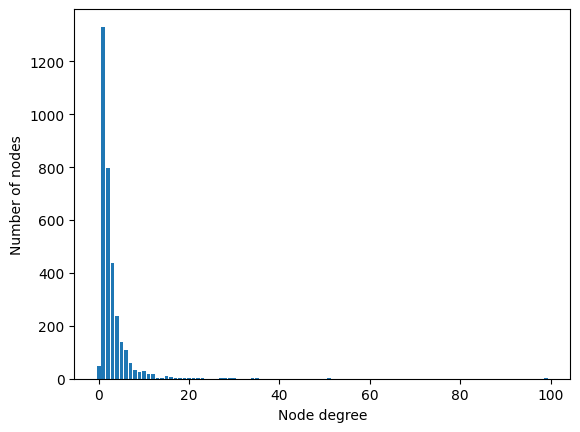

In [9]:
# Get list of degrees for each node
degrees = degree(dataset[0].edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [10]:
# Create the GAT GNN model
gat_cora = GAT(dataset.num_features, 16, dataset.num_classes)
print(gat_cora)

# Train
gat_cora.fit(data, epochs=100)

# Test
acc = gat_cora.test(data)
print(f'GAT test accuracy: {acc*100:.2f}%')

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)
Epoch   0 | Train Loss: 1.834 | Train Acc: 21.67% | Val Loss: 1.80 | Val Acc: 18.00%
Epoch  20 | Train Loss: 0.225 | Train Acc: 97.50% | Val Loss: 1.19 | Val Acc: 60.00%
Epoch  40 | Train Loss: 0.134 | Train Acc: 98.33% | Val Loss: 1.18 | Val Acc: 62.00%
Epoch  60 | Train Loss: 0.101 | Train Acc: 99.17% | Val Loss: 1.17 | Val Acc: 63.00%
Epoch  80 | Train Loss: 0.097 | Train Acc: 99.17% | Val Loss: 1.10 | Val Acc: 63.20%
Epoch 100 | Train Loss: 0.104 | Train Acc: 100.00% | Val Loss: 1.27 | Val Acc: 57.00%
GAT test accuracy: 64.80%


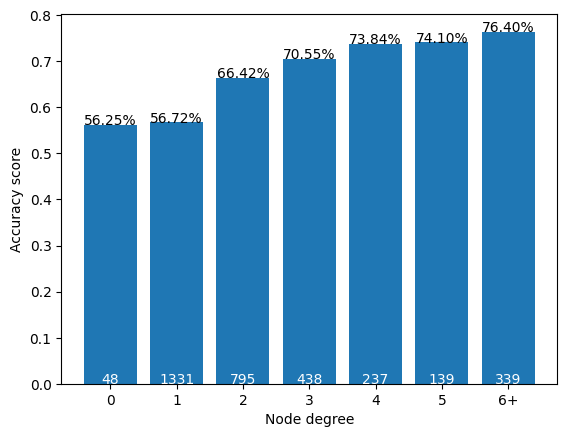

In [11]:
# Plot the average accuracy score for each node degree

# Get predicions
out = gat_cora(data.x, data.edge_index)

# Calculate the degree if each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','6+'], accuracies)
for i in range(0, 7):
  plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
for i in range(0, 7):
  plt.text(i, accuracies[i]//2, sizes[i], ha='center', color='white')

Nodes with few neighbors are harder to classify correctly